In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

## Ссылки:
* [Chris Olah's blog (LSTM/GRU)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [PyTorch tutorial - RNN for name classification](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)
* [MNIST classification with RNN tutorial](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79)
* [Good tutorials about Torch sentiment](https://github.com/bentrevett/pytorch-sentiment-analysis)

## Vanilla RNN

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" width="600">

$$\Large h_{i+1} = tanh(W_x \cdot X_{i+1} + W_y \cdot h_{i})$$

Рекурретные нейросети нужны для работы с **последовательными данными** произвольной длины. Они представляют собой абстрактные ячейки, у которых есть какая-то **память** (hidden state), которая обновляется после обработки очередной порции данных.

Если в самом простом виде, то в рекуррентных сетках для одного входного вектора $x_{(t)}$ и одного слоя рекуррентной сети справедливо такое соотношение:

$$y_{(t)} = \phi (x_{(t)}^T \cdot w_x + y_{(t-1)}^T \cdot w_y + b)$$

где 
* $x(t)$ — входной вектор на текущем шаге;
* $y(t)$ — выходной вектор на текущем шаге;
* $w_x$ — вектор весов нейронов для входа;
* $w_y$ — вектор весов нейронов для выхода;
* $y(t-1)$ — выходной вектор с прошлого шага (для первого шага этот вектор нулевой);
* $b$ — bias;
* $\phi$ — какая-то функция активации (например, ReLU).

Эту ячейку применяют по очереди ко всей последовательности, пробрасывая hidden state с предыдущего состояния. С точки зрения построения вычислительного графа это выглядит так:

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" width="600">

То есть если зафиксировать длину последовательности, то мы получим обычный фиксированный ациклический граф вычислений, в котором просто пошерены параметры всех ячеек.

### Упрощение формулы

Снова немножко математики чтобы привести формулу выше к более удобному виду.

Представим, что на вход подается не один вектор $x_{(t)}$, а целый мини-батч размера $m$ таких векторов $X_{(t)}$, соответственно все дальнейшие размышления мы уже производим в матричном виде:

$$ Y_{(t)} = \phi(X_{(t)}^T \cdot W_x + Y_{(t-1)}^T \cdot W_y + b) = \phi([X_{(t)} Y_{(t-1)}] \cdot W + b) $$
где
$$ W = [W_x W_y]^T $$

*Операция в квадратных скобках — конкатенация матриц

По размерностям:
* $Y_{(t)}$ — матрица [$m$ x n_neurons]
* $X_{(t)}$ — матрица [$m$ x n_features]
* $b$ — вектор длины n_neurons
* $W_x$ — веса между входами и нейронами размерностью [n_features x n_neurons]
* $W_y$ — веса связей с прошлым выходом размерностью [n_neurons x n_neurons]

# RNN from scratch

**Disclaimer:** не используйте самописные RNN-ки в реальной жизни.

Давайте реализуем торчовый модуль, который это реализует.

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        self.hidden_size = hidden_size
        self.W = nn.Linear(input_size + hidden_size, hidden_size)
        self.bias = torch.nn.init.normal_(torch.ones(hidden_size))
        self.activation = nn.Tanh()

    def forward(self, input_data, hidden):
        hidden = self.activation(self.W(torch.cat([input_data, hidden], 1)) + self.bias)
        return hidden

    def init_hidden(self, batch_size=1):
        return torch.zeros(batch_size, self.hidden_size)

In [ ]:
input_feature_size = 6
hidden_size = 5
batch_size = 7

In [ ]:
rnn = RNN(input_size=input_feature_size, hidden_size=hidden_size)
initial_hidden = rnn.init_hidden(batch_size)

In [ ]:
input_example = torch.rand([batch_size, input_feature_size])
new_hidden = rnn(input_example, initial_hidden)

In [ ]:
print(new_hidden.shape)

torch.Size([7, 5])


In [ ]:
print("initial_hidden: ", initial_hidden.numpy())
print("new_hidden: ", new_hidden.detach().numpy())

initial_hidden:  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
new_hidden:  [[ 0.95330834  0.84912586  0.42676324  0.4036587  -0.5384369 ]
 [ 0.95286095  0.823317    0.16919972  0.43527535 -0.54638267]
 [ 0.9154905   0.70393634  0.10291948  0.19510552 -0.5784752 ]
 [ 0.96133006  0.8464452   0.07556947  0.5601283  -0.58431464]
 [ 0.9518005   0.83714056  0.5259644   0.2950883  -0.55127484]
 [ 0.91427237  0.7309784   0.4713246   0.09905443 -0.60618716]
 [ 0.95378655  0.82625115  0.4737499   0.29338586 -0.5818714 ]]


In [ ]:
new_hidden = rnn(input_example, new_hidden)
print("new_hidden: ", new_hidden.detach().numpy())

new_hidden:  [[ 0.9550692   0.83786815  0.42368004  0.0319667  -0.34588283]
 [ 0.9490714   0.7933424   0.22356734  0.13600035 -0.31614527]
 [ 0.91653275  0.6701842   0.13502598 -0.08822185 -0.4039879 ]
 [ 0.9542775   0.8049804   0.17729871  0.29348093 -0.32195103]
 [ 0.9574376   0.83486533  0.49415928 -0.10735208 -0.39417326]
 [ 0.9295767   0.73283285  0.42466852 -0.2765727  -0.49377593]
 [ 0.95851046  0.8192078   0.4512227  -0.10285018 -0.4230335 ]]


**Задание**. Модифицируйте код так, чтобы на вход можно было подавать батчи размером больше 1.

# Классификация картинок с RNN

Представьте, что у вас есть какая-то длинная картинка, в которой свёртки точно не зайдут. Например, снимки со спутника, спектрограмма или длиннокот.

Можно обработать их построчно с помощью рекуррентных сетей — просто подавать в качестве входа все пиксели очередной строки.

<img src="https://cdn-images-1.medium.com/max/2000/1*wFYZpxTTiXVqncOLQd_CIQ.jpeg" width="800">

In [ ]:
!mkdir data

Загружаем данные

In [ ]:
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 64

# переводим все в тензоры
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
!ls -lh data/

total 4.0K
drwxr-xr-x 3 root root 4.0K May 20 07:45 MNIST


Populating the interactive namespace from numpy and matplotlib


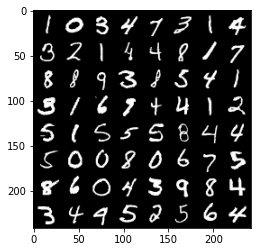

In [ ]:
%pylab inline
import numpy as np

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## Как выглядит классификация с RNN в общем виде 

<img src="https://cdn-images-1.medium.com/max/1600/1*vhAfRLlaeOXZ-bruv7Ostg.png" width="400">

In [ ]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super().__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

In [ ]:
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[ 0.0373, -0.0540,  0.0486, -0.1007, -0.0133,  0.0910,  0.0649,  0.1065,
         -0.1483, -0.1029],
        [ 0.0235, -0.0404,  0.0562, -0.0838, -0.0337,  0.1055,  0.0880,  0.0878,
         -0.1192, -0.1296],
        [ 0.0315, -0.0598,  0.0478, -0.0937, -0.0174,  0.0863,  0.0526,  0.1001,
         -0.1605, -0.1142],
        [ 0.0430, -0.0222,  0.0128, -0.1150, -0.0435,  0.0746,  0.0697,  0.0835,
         -0.1458, -0.0984],
        [ 0.0316, -0.0534,  0.0559, -0.0985, -0.0129,  0.0957,  0.0652,  0.0982,
         -0.1472, -0.1068],
        [ 0.0326, -0.0446,  0.0413, -0.1052, -0.0204,  0.0650,  0.0786,  0.0984,
         -0.1443, -0.0920],
        [ 0.0380, -0.0488,  0.0539, -0.1023, -0.0193,  0.0984,  0.0627,  0.1096,
         -0.1568, -0.0961],
        [ 0.0346, -0.0493,  0.0463, -0.0974, -0.0190,  0.1012,  0.0698,  0.1028,
         -0.1522, -0.0922],
        [ 0.0333, -0.0650,  0.0515, -0.0883, -0.0231,  0.0848,  0.0535,  0.0865,
         -0.1357, -0.0994],
        [ 0.0402, -

## Обучаем

In [ ]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
for epoch in range(N_EPHOCS):
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.6677 | Train Accuracy: 78.56
Epoch:  1 | Loss: 0.2926 | Train Accuracy: 91.76
Epoch:  2 | Loss: 0.2215 | Train Accuracy: 93.77
Epoch:  3 | Loss: 0.1821 | Train Accuracy: 94.89
Epoch:  4 | Loss: 0.1659 | Train Accuracy: 95.32
Epoch:  5 | Loss: 0.1484 | Train Accuracy: 95.84
Epoch:  6 | Loss: 0.1288 | Train Accuracy: 96.50
Epoch:  7 | Loss: 0.1257 | Train Accuracy: 96.52
Epoch:  8 | Loss: 0.1268 | Train Accuracy: 96.44
Epoch:  9 | Loss: 0.1110 | Train Accuracy: 96.94


### Смотрим что на тесте

In [ ]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 97.09


# Сентимент анализ

Домашка — классифицировать отзывы с IMDB на положительный / отрицательный только по тексту.

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment1.png">

Суть такая же, только нужно предобработать тексты — каждому слову сопоставить обучаемый вектор (embedding), который пойдёт дальше в RNN.

In [ ]:
# это уберет боль работы с текстами
!pip install torchtext==0.11.0
!python -m spacy download en

  Using cached torch-1.10.0-cp37-cp37m-manylinux1_x86_64.whl (881.9 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.10.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.10.0 which is incompatible.
     |████████████████████████████████| 12.0 MB 5.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


**Примечание.** Torchtext уже не очень живой проект, а в spacy нет русского.


In [ ]:
import torch
from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize='spacy', tokenizer_language = 'en_core_web_sm', include_lengths=True)
LABEL = data.LabelField(dtype=torch.float)

In [ ]:
from torchtext.legacy import datasets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL, root="./data")

In [ ]:
ls -lh data/imdb/aclImdb/

total 1.7M
-rw-r--r-- 1 7297 1000 882K Jun 11  2011 imdbEr.txt
-rw-r--r-- 1 7297 1000 827K Apr 12  2011 imdb.vocab
-rw-r--r-- 1 7297 1000 4.0K Jun 26  2011 README
drwxr-xr-x 4 7297 1000 4.0K Apr 12  2011 test/
drwxr-xr-x 5 7297 1000 4.0K Jun 26  2011 train/


In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [ ]:
print(vars(train_data.examples[0]))

{'text': ['CREEP', 'is', 'a', 'straight', 'up', 'serious', 'horror', 'film', 'set', 'in', 'real', 'time', 'that', 'wants', 'nothing', 'more', 'than', 'to', 'just', 'show', 'people', 'get', 'attacked', 'in', 'a', 'empty', 'subway', 'platform', 'by', 'a', 'mutant', 'for', '85', 'minutes', '.', 'And', 'it', 'does', 'just', 'that', '.', 'Nothing', 'more', ',', 'nothing', 'less', '.', 'Director', 'Christopher', 'Smith', 'draws', 'out', 'the', 'drama', 'a', 'far', 'as', 'he', 'plausibly', 'can', 'by', 'introducing', 'a', 'series', 'of', 'characters', 'that', 'would', 'actually', 'have', 'a', 'reason', 'to', 'be', 'in', 'the', 'subway', 'after', 'it', 'is', 'locked', '.', 'He', 'also', 'leaves', 'the', 'origins', 'of', 'the', 'titular', 'Creep', 'deliberately', 'vague', '(', 'unlawful', 'experiments', 'happening', 'in', 'the', '60s', 'underground', 'are', 'hinted', 'at', ')', 'and', 'that', 'little', 'bit', 'of', 'mystery', 'works', 'for', 'the', 'most', 'part', '.', 'Sadly', ',', 'he', 'unde

In [ ]:
# Сделаем еще eval
import random

train_data, valid_data = train_data.split(random_state=random.seed(SEED))

In [ ]:
# Сделаем словарь
TEXT.build_vocab(train_data, max_size=25000)
LABEL.build_vocab(train_data)

In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [ ]:
vars(LABEL.vocab)

{'freqs': Counter({'neg': 8810, 'pos': 8690}),
 'itos': ['neg', 'pos'],
 'stoi': defaultdict(None, {'neg': 0, 'pos': 1}),
 'unk_index': None,
 'vectors': None}

Почему 25002, а не 25000?
Потому что $<unk>$ и $<pad>$

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment6.png" width="160">

In [ ]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 203325), (',', 192715), ('.', 166053), ('and', 109620), ('a', 109403), ('of', 100857), ('to', 93979), ('is', 76335), ('in', 61613), ('I', 54402), ('it', 53767), ('that', 49330), ('"', 44152), ("'s", 43462), ('this', 42159), ('-', 37218), ('/><br', 35858), ('was', 35049), ('as', 30385), ('with', 30061)]


* stoi (string to int)
* itos (int to string)

In [ ]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


In [ ]:
print(LABEL.vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})


### Установим дополнительные библиотеки. Sentence transformers для извлечения более качественных и осмысленных эмбеддингов, nltk - для предобработки текстов

P.S. Наверное, для данной задачи это оверкилл, но я решил попробовать 😀

In [ ]:
!pip install -q -U sentence-transformers
!pip install -q nltk

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.


In [ ]:
from sentence_transformers import SentenceTransformer

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import re

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
embedder = SentenceTransformer('all-MiniLM-L6-v2', device=device) # трансформер для извлечения эмбеддингов
lemmatizer = WordNetLemmatizer() # лемматизатор
word_regex = re.compile(r'[a-zA-Zа-яА-Я]+') # а этим будем очищать текст от знаков препинания и пробелов
russian_stopwords = stopwords.words('russian') # этим будем чистить текст от стоп-слов
english_spotwords = stopwords.words('english') #

def preprocess_text(text):
  text = list(map(lambda word: word.lower(), word_regex.findall(' '.join(text)))) # удаляем знаки препинания и пробелы, делаем lowercase
  text = [lemmatizer.lemmatize(word) for word in text] # находим леммы слов
  text = [word for word in text if word not in russian_stopwords  and  word not in english_spotwords] # удаляем стоп-слова
  text = ' '.join(text) # склеиваем через пробел (эмбеддер, увы, принимает только строки)
  embedding = embedder.encode(text, convert_to_tensor=True, normalize_embeddings=True, device=device).view(1, 384) # находим эмбеддинги
  # 384 - размер эмбеддингов, которые возвращает используемая модель
  return embedding

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from torch.utils.data import Dataset, DataLoader

class IMDBDataset(Dataset):
  def __init__(self, torchtext_dataset):
    super().__init__()
    text_embeddings = []
    labels = []
    for i in range(len(torchtext_dataset.examples)):
      comment = vars(torchtext_dataset.examples[i])['text'] # берем один отзыв
      embedding = preprocess_text(comment) # находим его эмбеддинг

      label = 1 if vars(torchtext_dataset.examples[i])['label'] == 'pos' else 0 # кодируем лэйблы
      text_embeddings.append(embedding)
      labels.append(label)

    self.text_embeddings = text_embeddings
    self.labels = torch.tensor(labels)

  def __len__(self):
    return len(self.labels)
  
  def __getitem__(self, idx):
    return self.text_embeddings[idx], self.labels[idx]

### Определяем train/eval dataset/dataloader

In [ ]:
BATCH_SIZE = 64

train_dataset = IMDBDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

eval_dataset = IMDBDataset(valid_data)
eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Делаем модель

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment7.png" width="450">

* В эмбеддер (emb = [torch.nn.Embedding(num_embeddings, embedding_dim)](https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding)) запихиваем тензор размерностью **[sentence length, batch size]**
* Эмбеддер возвращает тензор размерностью **[sentence length, batch size, embedding dim]**
* RNN (torch.nn.RNN(embedding_dim, hidden_dim)) возвращает 2 тензора, *output* размера [sentence length, batch size, hidden dim] и *hidden* размера [1, batch size, hidden dim]

In [ ]:
from torch import nn

class RNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers=2, 
                            bidirectional=True,
                            dropout=0.2,
                            batch_first=True)
        self.linear = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, embeddings):
        packed_output, (hidden, cell) = self.lstm(embeddings)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)   
        return self.linear(hidden)

### Обучаемся

In [ ]:
embedding_dim = 384
hidden_dim = 128
output_dim = 1

model = RNN(embedding_dim, hidden_dim, output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
def accuracy(preds, labels):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == labels).float()
    return correct.sum() / len(correct)

In [ ]:
N_EPOCHS = 10
best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
    train_loss = 0
    train_acc = 0
    valid_loss = 0
    valid_acc = 0

    for embeddings, labels in train_loader:
        embeddings, labels = embeddings.to(device), labels.to(device)
        optimizer.zero_grad()

        predictions = model(embeddings).squeeze(1)
        loss = criterion(predictions, labels.float())
        acc = accuracy(predictions, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += acc.item()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    with torch.no_grad():
        for valid_data in eval_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)

            predictions = model(embeddings).squeeze(1)
            loss = criterion(predictions, labels.float())
            acc = accuracy(predictions, labels)
            valid_loss += loss.item()
            valid_acc += acc.item()
    
    valid_loss /= len(eval_loader)
    valid_acc /= len(eval_loader)
      
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    
    print(f'Epoch {epoch}')
    print(f'\tTrain | Loss: {train_loss:.4f} | Accuracy: {train_acc*100:.2f}%') 
    print(f'\tValid | Loss: {valid_loss:.4f} | Accuracy: {valid_acc*100:.2f}%') 

Epoch 0
	Train | Loss: 0.4612 | Accuracy: 77.11%
	Valid | Loss: 0.4074 | Accuracy: 78.18%
Epoch 1
	Train | Loss: 0.3976 | Accuracy: 81.88%
	Valid | Loss: 0.4212 | Accuracy: 79.06%
Epoch 2
	Train | Loss: 0.3895 | Accuracy: 82.08%
	Valid | Loss: 0.3110 | Accuracy: 85.71%
Epoch 3
	Train | Loss: 0.3872 | Accuracy: 82.37%
	Valid | Loss: 0.2947 | Accuracy: 88.20%
Epoch 4
	Train | Loss: 0.3799 | Accuracy: 82.53%
	Valid | Loss: 0.2944 | Accuracy: 95.55%
Epoch 5
	Train | Loss: 0.3746 | Accuracy: 82.64%
	Valid | Loss: 0.4532 | Accuracy: 82.14%
Epoch 6
	Train | Loss: 0.3712 | Accuracy: 82.93%
	Valid | Loss: 0.3043 | Accuracy: 85.71%
Epoch 7
	Train | Loss: 0.3673 | Accuracy: 83.02%
	Valid | Loss: 0.3699 | Accuracy: 82.38%
Epoch 8
	Train | Loss: 0.3650 | Accuracy: 83.24%
	Valid | Loss: 0.4031 | Accuracy: 85.53%
Epoch 9
	Train | Loss: 0.3582 | Accuracy: 83.57%
	Valid | Loss: 0.2755 | Accuracy: 92.86%


### Тестируемся

In [ ]:
test_dataset = IMDBDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
test_loss = 0
test_acc = 0
with torch.no_grad():
  for valid_data in test_loader:
    embeddings, labels = embeddings.to(device), labels.to(device)

    predictions = model(embeddings).squeeze(1)
    loss = criterion(predictions, labels.float())
    acc = accuracy(predictions, labels)
    test_loss += loss.item()
    test_acc += acc.item()

  test_loss /= len(test_loader)
  test_acc /= len(test_loader)

In [ ]:
print(f'Test loss: {test_loss:.4f}, test_acc: {test_acc * 100:.2f}%')

Test loss: 0.2749, test_acc: 92.86%
